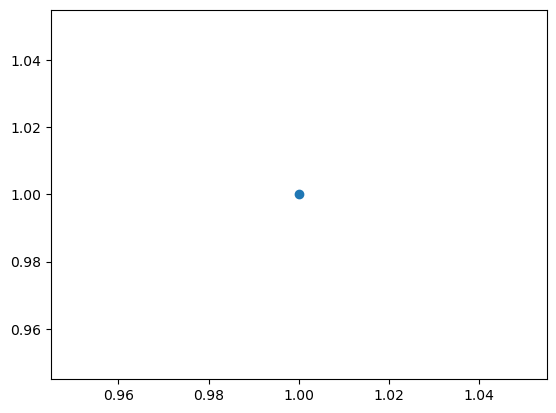

In [1]:
import matplotlib.pyplot as plt
plt.scatter(1,1)

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

In [3]:
main_dir = 'datasets'
set_dir = 'IMAGENET100'
train_dir = 'train'
test_dir = 'test'

In [83]:
class SparseCAE_layer05 (nn.Module):
    def __init__(self, in_ch, sparsity_lambda=1e-3):
        super().__init__()
        
        self.sparsity_lambda = sparsity_lambda
        self.bn3n = nn.BatchNorm2d(2*in_ch)
        
        self.encoder = nn.Conv2d(in_ch, 2*in_ch, kernel_size=4, stride=2, padding=1)
        self.decoder = nn.ConvTranspose2d(2*in_ch, in_ch, kernel_size=4, stride=2, padding=1)
        
    def forward(self, X):     

        X = torch.relu(self.bn3n(self.encoder(X)))
        X = torch.relu(self.decoder(X))
        
        return X
        
    def encode(self, X):
        return torch.relu(self.bn3n(self.encoder(X)))
        
    def decode(self, X):
        return torch.relu(self.decoder(X))
        
    def loss_function(self, x, decoded, encoded):
        
        recon_loss = F.mse_loss(decoded, x, reduction='mean')
        sparsity_loss = torch.mean(torch.abs(encoded))
        return recon_loss + self.sparsity_lambda * sparsity_loss

In [84]:
class Sparce_FDSCAE (nn.Module):
    def __init__(self, sparsity_lambda=1e-3):
        super().__init__()
        self.active_depht = 1
        self.lern_last_only = True
        self.sparsity_lambda = sparsity_lambda

        self.l1 = SparseCAE_layer05(3)
        self.l2 = SparseCAE_layer05(6)
        self.l3 = SparseCAE_layer05(12)
        self.l4 = SparseCAE_layer05(24)
        self.l5 = SparseCAE_layer05(48)
        self.l6 = SparseCAE_layer05(96)
        
        self.layers = [self.l1,
                       self.l2,
                       self.l3,
                       self.l4,
                       self.l5,
                       self.l6]
        
    def forward(self, X):
        X = self.encode(X)
        LAT = X
        X = self.decode(X)
        return X, LAT
        
    def encode(self, X):
        if self.lern_last_only:
            for i in range(self.active_depht - 1):
                self.layers[i].eval()
            self.layers[self.active_depht - 1].train()
        else:
            self.train()
            
        for layer in self.layers[:self.active_depht]:
            
            X = layer.encode(X)
            
        return X
        
    def decode(self, X):
        if self.lern_last_only:
            for i in range(self.active_depht - 1):
                self.layers[i].eval()
            self.layers[self.active_depht - 1].train()
        else:
            self.train()
            
        for layer in list(reversed(self.layers[:self.active_depht])):
            X = layer.decode(X)
            
        return X
        
    def loss_function(self, x, decoded, encoded):
        recon_loss = F.mse_loss(decoded, x, reduction='mean')
        sparsity_loss = torch.mean(torch.abs(encoded))
        return recon_loss + self.sparsity_lambda * sparsity_loss

In [1]:
train_transforms = transforms.Compose([
                                       transforms.Resize((64, 64)),
                                       transforms.ToTensor()
                                      ])
test_transforms = train_transforms

TRAIN_DATA = datasets.ImageFolder(os.path.join(main_dir, set_dir, train_dir), transform=train_transforms)
TEST_DATA = datasets.ImageFolder(os.path.join(main_dir, set_dir, test_dir), transform=test_transforms)

NameError: name 'transforms' is not defined

In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Sparce_FDSCAE().to(device)
epoche = 0

In [143]:
epochs = 1000000
learning_rate = 0.0001
optimizer = torch.optim.RAdam(model.parameters(), learning_rate, weight_decay=0.0001)

BATCH_SIZE = 2048#len(TEST_DATA)
           
train_loader = torch.utils.data.DataLoader(TRAIN_DATA, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(TEST_DATA, batch_size=BATCH_SIZE, shuffle=True)

In [144]:
model.active_depht = 5
model.lern_last_only = 0
auto_skip = 0

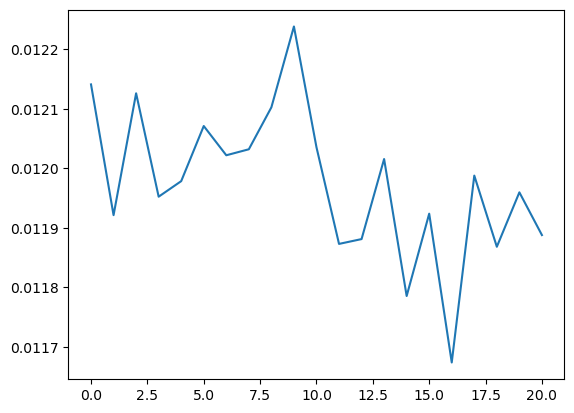

KeyboardInterrupt: 

In [145]:
from IPython.display import clear_output
%matplotlib inline

cnt = 0
hist = []
for cur in range(epochs):
        epoche += 1 
        last = 999
        for x, _ in train_loader:
            inputs, labels = x.to(device), x.to(device)
            optimizer.zero_grad()
            outputs, embedding = model(inputs)
            
            loss = model.loss_function(labels, outputs, embedding)
            
            loss.backward()
            optimizer.step()

            cnt += 1
            if not cnt % 1:
                hist.append(loss.detach().cpu().numpy())
                if abs((last / loss) - 1) < 0.02 and auto_skip:
                    if not model.lern_last_only:
                        model.active_depht += 1
                    model.lern_last_only = not model.lern_last_only
                last = loss

                clear_output(True)
                plt.plot(range(len(hist)), hist)
                plt.show()
                
            print(f"Эпоха: {epoche}, глуб. {model.active_depht} , ошибка  {loss}",
                  sep='', end='\r')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


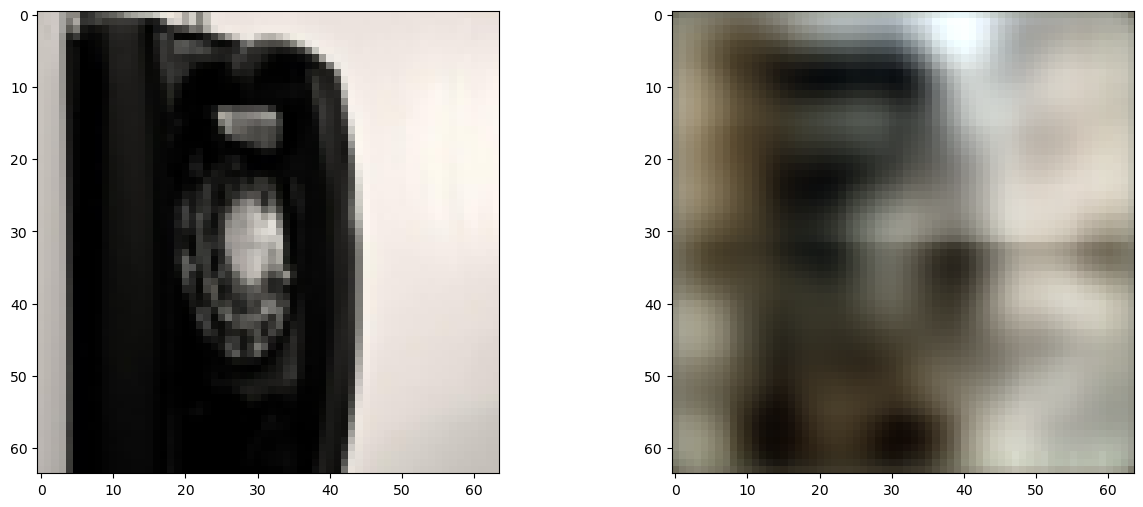

In [142]:
model.eval()
rnd_im = TRAIN_DATA[np.random.randint(0, len(TRAIN_DATA))][0]
ans = model(rnd_im.unsqueeze(0).to(device))[0].cpu().detach()
ans = np.array(ans.view(3,64,64)).transpose((1, 2, 0))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[1].imshow(ans)
ax[0].imshow(np.transpose(rnd_im, (1,2,0)))

In [147]:
torch.save(model, 'AE_64x3_384_012.pth')

<div style="font-size:32px; line-height:1.4;">
    <b>Дообучение авто-кодировщика:</b><br>
</div>

In [150]:
main_dir_apt = 'datasets'
set_dir_apt = 'DeepCluster_ds'
train_dir_apt = 'train'

In [151]:
train_transforms = transforms.Compose([
                                       transforms.Resize((64, 64)),
                                       transforms.ToTensor()
                                      ])

TRAIN_DATA_SEC = datasets.ImageFolder(os.path.join(main_dir_apt, set_dir_apt, train_dir_apt), transform=train_transforms)

In [167]:
pretrain_model = torch.load('AE_64x3_384_012.pth', weights_only=False)
pretrain_model.eval()
epoche = 0

In [164]:
epochs = 1000000
learning_rate = 0.1
optimizer = torch.optim.RAdam(pretrain_model.parameters(), learning_rate, weight_decay=0.0001)

BATCH_SIZE = 16#len(TEST_DATA)
           
train_loader = torch.utils.data.DataLoader(TRAIN_DATA_SEC, batch_size=BATCH_SIZE, shuffle=True)

In [165]:
pretrain_model.active_depht = 5
pretrain_model.lern_last_only = 0
auto_skip = 1

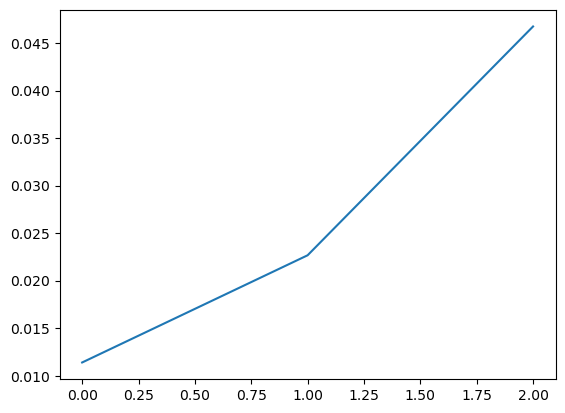

KeyboardInterrupt: 

In [166]:
hist = []
for cur in range(epochs):
        epoche += 1 
        last = 999
        for x, _ in train_loader:
            inputs, labels = x.to(device), x.to(device)
            optimizer.zero_grad()
            outputs, embedding = pretrain_model(inputs)
            
            loss = pretrain_model.loss_function(labels, outputs, embedding)
            
            loss.backward()
            optimizer.step()

            cnt += 1
            if not cnt % 10:
                hist.append(loss.detach().cpu().numpy())
                if abs((last / loss) - 1) < 0.02 and auto_skip:
                    if not pretrain_model.lern_last_only:
                        pretrain_model.active_depht += 1
                    pretrain_model.lern_last_only = not pretrain_model.lern_last_only
                last = loss

                clear_output(True)
                plt.plot(range(len(hist)), hist)
                plt.show()
                
            print(f"Эпоха: {epoche}, глуб. {pretrain_model.active_depht} , ошибка  {loss}",
                  sep='', end='\r')

In [168]:
from sklearn.cluster import KMeans

In [169]:
class DEC(nn.Module):
    def __init__(self, autoencoder, n_clusters=10, alpha=1.0):
        super(DEC, self).__init__()
        self.autoencoder = autoencoder
        self.n_clusters = n_clusters
        self.alpha = alpha

        # Замораживаем автокодировщик (можно разморозить позже при совместном обучении)
        for param in self.autoencoder.parameters():
            param.requires_grad = False

        # Центроиды кластеров: (n_clusters, latent_dim)
        self.cluster_centers = nn.Parameter(torch.zeros(n_clusters, 384))

    def encode(self, x):
        return self.autoencoder.encode(x)

    def decode(self, z):
        return self.autoencoder.decode(z)

    def soft_assign(self, z):
        # z: (batch_size, 384)
        # q_ij = 1 / (1 + ||z_i - mu_j||^2 / alpha)
        dist = torch.cdist(z, self.cluster_centers)  # (B, K)
        q = 1.0 / (1.0 + dist ** 2 / self.alpha)
        q = q ** ((self.alpha + 1) / 2)
        q = q / q.sum(dim=1, keepdim=True)
        return q

    def target_distribution(self, q):
        # p_ij = q_ij^2 / sum_i q_ij  --> усиление уверенности
        weight = q ** 2 / q.sum(dim=0, keepdim=True)
        p = weight / weight.sum(dim=1, keepdim=True)
        return p.detach()

    def forward(self, x):
        z = self.encode(x)
        q = self.soft_assign(z)
        return z, q

In [170]:
def train_dec(model, dataloader, optimizer, device, n_epochs=20):
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)

            # Forward
            z, q = model(x)
            p = model.target_distribution(q)

            # KL divergence loss
            loss = F.kl_div(q.log(), p, reduction='batchmean')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(dataloader):.6f}')

In [171]:
def init_cluster_centers(model, dataloader, device, n_clusters=10):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            z = model.encode(x)
            embeddings.append(z.cpu())
    embeddings = torch.cat(embeddings, dim=0).numpy()

    # K-means
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    kmeans.fit(embeddings)
    model.cluster_centers.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

In [172]:
n_clusters = 2  # задайте нужное число кластеров
dec_model = DEC(pretrain_model, n_clusters=n_clusters).to(device)

# Инициализация центроидов
init_cluster_centers(dec_model, train_loader, device, n_clusters=n_clusters)

# Оптимизатор (только для cluster_centers)
optimizer = torch.optim.SGD(dec_model.parameters(), lr=0.01, momentum=0.9)

# Обучение DEC
train_dec(dec_model, train_loader, optimizer, device, n_epochs=20)

ValueError: Found array with dim 4. KMeans expected <= 2.